In [ ]:
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import sys, time, os, warnings
warnings.filterwarnings("ignore")
import re

from numpy import array
from pickle import load
from PIL import Image
import pickle
from collections import Counter
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.applications.vgg16 import VGG16, preprocess_input

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/My Drive/Images.zip"

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: __MACOSX/Images/._2844846111_8c1cbfc75d.jpg  
  inflating: Images/1082252566_8c79beef93.jpg  
  inflating: __MACOSX/Images/._1082252566_8c79beef93.jpg  
  inflating: Images/1386251841_5f384a0fea.jpg  
  inflating: __MACOSX/Images/._1386251841_5f384a0fea.jpg  
  inflating: Images/2196316998_3b2d63f01f.jpg  
  inflating: __MACOSX/Images/._2196316998_3b2d63f01f.jpg  
  inflating: Images/3106791484_13e18c33d8.jpg  
  inflating: __MACOSX/Images/._3106791484_13e18c33d8.jpg  
  inflating: Images/3603064161_a8f3b6455d.jpg  
  inflating: __MACOSX/Images/._3603064161_a8f3b6455d.jpg  
  inflating: Images/2293149170_38fb2257ea.jpg  
  inflating: __MACOSX/Images/._2293149170_38fb2257ea.jpg  
  inflating: Images/2451114871_8617ae2f16.jpg  
  inflating: __MACOSX/Images/._2451114871_8617ae2f16.jpg  
  inflating: Images/3711030008_3872d0b03f.jpg  
  inflating: __MACOSX/Images/._3711030008_387

In [ ]:
image_path = "Images"
dir_Flickr_text = "/content/drive/My Drive/captions.txt"
jpgs = os.listdir(image_path)

print("Total Images in Dataset = {}".format(len(jpgs)))

Total Images in Dataset = 8091


In [ ]:
doc = open(dir_Flickr_text,'r').read()
print(doc[:415])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .



In [ ]:
file = open(dir_Flickr_text,'r')
next(file)
text = file.read()
file.close()

datatxt = []
count = 0
for line in text.split('\n'):
   col = line.split('\t')

   w = col[0].split(",")
   if len(w) < 2:
     continue

   datatxt.append([count,w[0],w[1].lower()])
   count += 1

data = pd.DataFrame(datatxt,columns=["index","filename","caption"])
uni_filenames = np.unique(data.filename.values)

data.head()

,index,filename,caption
0,0,1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set o...
1,1,1000268201_693b08cb0e.jpg,a girl going into a wooden building .
2,2,1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse .
3,3,1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playh...
4,4,1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a woo...


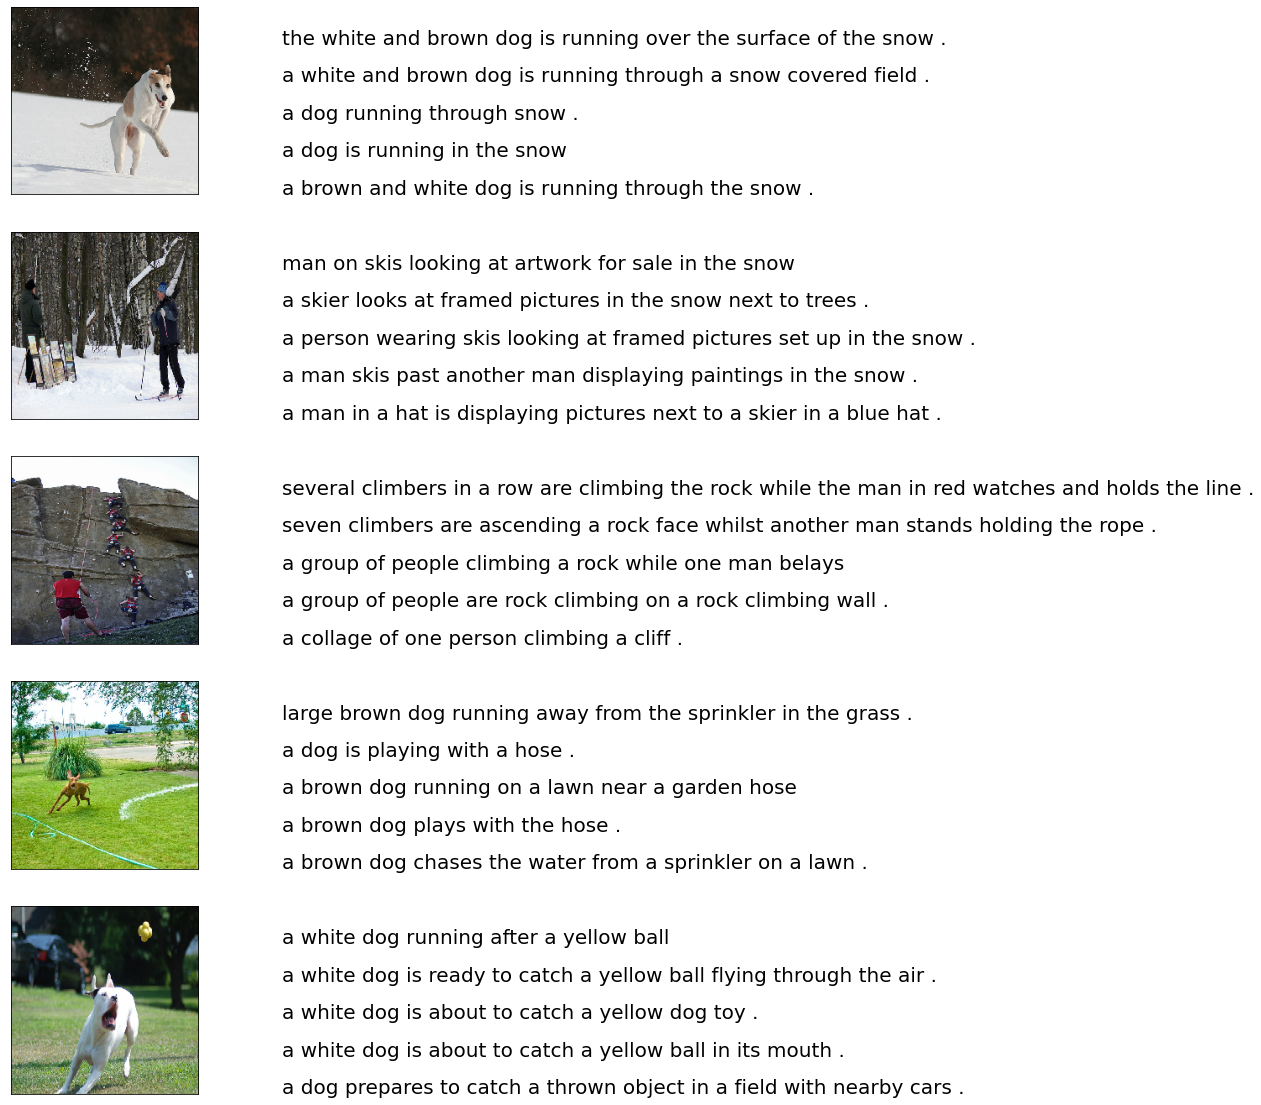

In [ ]:
npic = 5
npix = 224
target_size = (npix,npix,3)
count = 1

fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[10:15]:
   filename = image_path + '/' + jpgfnm
   captions = list(data["caption"].loc[data["filename"]==jpgfnm].values)
   image_load = load_img(filename, target_size=target_size)
   ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
   ax.imshow(image_load)
   count += 1

   ax = fig.add_subplot(npic,2,count)
   plt.axis('off')
   ax.plot()
   ax.set_xlim(0,1)
   ax.set_ylim(0,len(captions))
   for i, caption in enumerate(captions):
       ax.text(0,i,caption,fontsize=20)
   count += 1
plt.show()

In [ ]:
vocabulary = []
for txt in data.caption.values:
   vocabulary.extend(txt.split())
print('Vocabulary Size: %d' % len(set(vocabulary)))

Vocabulary Size: 8871


In [ ]:
def remove_punctuation(text_original):
   text_no_punctuation = text_original.translate(string.punctuation)
   return(text_no_punctuation)

def remove_single_character(text):
   text_len_more_than1 = ""
   for word in text.split():
       if len(word) > 1:
           text_len_more_than1 += " " + word
   return(text_len_more_than1)

def remove_numeric(text):
   text_no_numeric = ""
   for word in text.split():
       isalpha = word.isalpha()
       if isalpha:
           text_no_numeric += " " + word
   return(text_no_numeric)

def text_clean(text_original):
   text = remove_punctuation(text_original)
   text = remove_single_character(text)
   text = remove_numeric(text)
   return(text)

for i, caption in enumerate(data.caption.values):
   newcaption = text_clean(caption)
   data["caption"].iloc[i] = newcaption

In [ ]:
clean_vocabulary = []
for txt in data.caption.values:
   clean_vocabulary.extend(txt.split())
print('Clean Vocabulary Size: %d' % len(set(clean_vocabulary)))

Clean Vocabulary Size: 8182


In [ ]:
PATH = "Images/"
all_captions = []
for caption  in data["caption"].astype(str):
   caption = '<start> ' + caption+ ' <end>'
   all_captions.append(caption)

all_captions[:10]

['<start>  child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start>  girl going into wooden building <end>',
 '<start>  little girl climbing into wooden playhouse <end>',
 '<start>  little girl climbing the stairs to her playhouse <end>',
 '<start>  little girl in pink dress going into wooden cabin <end>',
 '<start>  black dog and spotted dog are fighting <end>',
 '<start>  black dog and dog playing with each other on the road <end>',
 '<start>  black dog and white dog with brown spots are staring at each other in the street <end>',
 '<start>  two dogs of different breeds looking at each other on the road <end>',
 '<start>  two dogs on pavement moving toward each other <end>']

In [ ]:
all_img_name_vector = []
for annot in data["filename"]:
   full_image_path = PATH + annot
   all_img_name_vector.append(full_image_path)

all_img_name_vector[:10]

['Images/1000268201_693b08cb0e.jpg',
 'Images/1000268201_693b08cb0e.jpg',
 'Images/1000268201_693b08cb0e.jpg',
 'Images/1000268201_693b08cb0e.jpg',
 'Images/1000268201_693b08cb0e.jpg',
 'Images/1001773457_577c3a7d70.jpg',
 'Images/1001773457_577c3a7d70.jpg',
 'Images/1001773457_577c3a7d70.jpg',
 'Images/1001773457_577c3a7d70.jpg',
 'Images/1001773457_577c3a7d70.jpg']

In [ ]:
print(f"len(all_img_name_vector) : {len(all_img_name_vector)}")
print(f"len(all_captions) : {len(all_captions)}")

len(all_img_name_vector) : 40455
len(all_captions) : 40455


In [ ]:
def data_limiter(num,total_captions,all_img_name_vector):
 train_captions, img_name_vector = shuffle(total_captions,all_img_name_vector,random_state=1)
 train_captions = train_captions[:num]
 img_name_vector = img_name_vector[:num]
 return train_captions,img_name_vector

train_captions,img_name_vector = data_limiter(40000,all_captions,all_img_name_vector)

In [ ]:
def load_image(image_path):
   img = tf.io.read_file(image_path)
   img = tf.image.decode_jpeg(img, channels=3)
   img = tf.image.resize(img, (224, 224))
   img = preprocess_input(img)
   return img, image_path

image_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

image_features_extract_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [ ]:
encode_train = sorted(set(img_name_vector))
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

In [ ]:
%%time
for img, path in tqdm(image_dataset):
 batch_features = image_features_extract_model(img)
 batch_features = tf.reshape(batch_features,
                             (batch_features.shape[0], -1, batch_features.shape[3]))


 for bf, p in zip(batch_features, path):
   path_of_feature = p.numpy().decode("utf-8")
   np.save(path_of_feature, bf.numpy())

100%|██████████| 127/127 [01:21<00:00,  1.55it/s]

CPU times: user 1min 20s, sys: 5.44 s, total: 1min 26s
Wall time: 1min 22s


In [ ]:
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                 oov_token="<unk>",
                                                 filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

train_seqs = tokenizer.texts_to_sequences(train_captions)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [ ]:
train_captions[:3]

['<start>  several children leaping into pile of leaves on the ground <end>',
 '<start>  man hiking in the wilderness giving the camera thumbs up <end>',
 '<start>  white dog is running through the water onto the shore <end>']

In [ ]:
train_seqs[:3]

[[2, 185, 60, 332, 63, 506, 12, 328, 6, 5, 169, 3],
 [2, 11, 569, 4, 5, 2841, 895, 5, 94, 1270, 53, 3],
 [2, 14, 9, 7, 32, 33, 5, 24, 238, 5, 284, 3]]

In [ ]:
def calc_max_length(tensor):
   return max(len(t) for t in tensor)
max_length = calc_max_length(train_seqs)

def calc_min_length(tensor):
   return min(len(t) for t in tensor)
min_length = calc_min_length(train_seqs)

print('Max Length of any caption : Min Length of any caption = '+ str(max_length) +" : "+str(min_length))

Max Length of any caption : Min Length of any caption = 31 : 2


In [ ]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,cap_vector, test_size=0.2, random_state=0)

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE
features_shape = 512
attention_features_shape = 49

In [ ]:
def map_func(img_name, cap):
 img_tensor = np.load(img_name.decode('utf-8')+'.npy')
 return img_tensor, cap
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

dataset = dataset.map(lambda item1, item2: tf.numpy_function(
        map_func, [item1, item2], [tf.float32, tf.int32]),
         num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
class VGG16_Encoder(tf.keras.Model):
   def __init__(self, embedding_dim):
       super(VGG16_Encoder, self).__init__()
       self.fc = tf.keras.layers.Dense(embedding_dim)
       self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)

   def call(self, x):
       x = self.fc(x)
       x = tf.nn.relu(x)
       return x   

In [ ]:
def rnn_type(units):
   if tf.test.is_gpu_available():
       return tf.compat.v1.keras.layers.CuDNNLSTM(units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
   else:
       return tf.keras.layers.GRU(units,
                                  return_sequences=True,
                                  return_state=True,
                                  recurrent_activation='sigmoid',
                                  recurrent_initializer='glorot_uniform')

In [ ]:
class Rnn_Global_Decoder(tf.keras.Model):
    def _init_(self, embedding_dim, units, vocab_size,scoring_type):
        super(Rnn_Global_Decoder, self)._init_()
        

        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        
        
        
        self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
        
        self.wc = tf.keras.layers.Dense(units, activation='tanh')
        self.ws = tf.keras.layers.Dense(vocab_size)

        #For Attention
        self.wa = tf.keras.layers.Dense(units)
        self.wb = tf.keras.layers.Dense(units)
        
       
        self.Vattn = tf.keras.layers.Dense(1)
        self.wd = tf.keras.layers.Dense(units, activation='tanh')

        self.scoring_type = scoring_type

        
    def call(self, sequence, features,hidden):
        
        embed = self.embedding(sequence)
       
        output, state = self.gru(embed)       

        score=0
        
     
        if(self.scoring_type=='general'):
          score = tf.matmul(output, self.wa(features), transpose_b=True)
        
        alignment = tf.nn.softmax(score, axis=2)

        context = tf.matmul(alignment, features)
   
        output = tf.concat([tf.squeeze(context, 1), tf.squeeze(output, 1)], 1)
      
        output = self.wc(output)
       
        logits = self.ws(output)
       
        return logits, state, alignment

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [ ]:
class Rnn_Local_Decoder(tf.keras.Model):
 def __init__(self, embedding_dim, units, vocab_size):
   super(Rnn_Local_Decoder, self).__init__()
   self.units = units
   self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
   self.gru = tf.keras.layers.GRU(self.units,
                                  return_sequences=True,
                                  return_state=True,
                                  recurrent_initializer='glorot_uniform')
  
   self.fc1 = tf.keras.layers.Dense(self.units)

   self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)
   self.batchnormalization = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)

   self.fc2 = tf.keras.layers.Dense(vocab_size)

   # Implementing Attention Mechanism
   self.Uattn = tf.keras.layers.Dense(units)
   self.Wattn = tf.keras.layers.Dense(units)
   self.Vattn = tf.keras.layers.Dense(1)

 def call(self, x, features, hidden):

   hidden_with_time_axis = tf.expand_dims(hidden, 1)

   score = self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)))

   attention_weights = tf.nn.softmax(score, axis=1)

   context_vector = attention_weights * features
   context_vector = tf.reduce_sum(context_vector, axis=1)

   x = self.embedding(x)

   x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

   output, state = self.gru(x)

   x = self.fc1(output)

   x = tf.reshape(x, (-1, x.shape[2]))

   x= self.dropout(x)
   x= self.batchnormalization(x)

   x = self.fc2(x)

   return x, state, attention_weights

 def reset_state(self, batch_size):
   return tf.zeros((batch_size, self.units))


In [ ]:
class Rnn_Global_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size,scoring_type):
        super(Rnn_Global_Decoder, self).__init__()
        

        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        
        
        
        self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
        
        self.wc = tf.keras.layers.Dense(units, activation='tanh')
        self.ws = tf.keras.layers.Dense(vocab_size)

     
        self.wa = tf.keras.layers.Dense(units)
        self.wb = tf.keras.layers.Dense(units)
        
     
        self.Vattn = tf.keras.layers.Dense(1)
        self.wd = tf.keras.layers.Dense(units, activation='tanh')

        self.scoring_type = scoring_type

        
    def call(self, sequence, features,hidden):
              
        embed = self.embedding(sequence)

        output, state = self.gru(embed)       
     
        score=0

        # General Score
        if(self.scoring_type=='general'):
          score = tf.matmul(output, self.wa(features), transpose_b=True)

        # alignment vector
        alignment = tf.nn.softmax(score, axis=2)
    
        # context vector c_t is the average sum of encoder output
        context = tf.matmul(alignment, features)
     
        # Combine the context vector and the LSTM output  
        output = tf.concat([tf.squeeze(context, 1), tf.squeeze(output, 1)], 1)

        output = self.wc(output)
     
        logits = self.ws(output)

        return logits, state, alignment

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [ ]:
encoder = VGG16_Encoder(embedding_dim)
decoder = Rnn_Local_Decoder(embedding_dim, units, vocab_size)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
   from_logits=True, reduction='none')

def loss_function(real, pred):
 mask = tf.math.logical_not(tf.math.equal(real, 0))
 loss_ = loss_object(real, pred)
 mask = tf.cast(mask, dtype=loss_.dtype)
 loss_ *= mask

 return tf.reduce_mean(loss_)

In [ ]:
loss_plot = []

@tf.function
def train_step(img_tensor, target):
 loss = 0

 hidden = decoder.reset_state(batch_size=target.shape[0])
 dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

 with tf.GradientTape() as tape:
     features = encoder(img_tensor)
     for i in range(1, target.shape[1]):
         predictions, hidden, _ = decoder(dec_input, features, hidden)
         loss += loss_function(target[:, i], predictions)

         dec_input = tf.expand_dims(target[:, i], 1)

 total_loss = (loss / int(target.shape[1]))
 trainable_variables = encoder.trainable_variables + decoder.trainable_variables
 gradients = tape.gradient(loss, trainable_variables)
 optimizer.apply_gradients(zip(gradients, trainable_variables))

 return loss, total_loss


In [ ]:
EPOCHS = 15
start_epoch = 0
for epoch in range(start_epoch, EPOCHS):
  start = time.time()
  total_loss = 0

  for(batch, (img_tensor, target)) in enumerate(dataset):
    batch_loss, t_loss = train_step(img_tensor, target)
    total_loss += t_loss
    if batch % 100 == 0:
      print ('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
  
  loss_plot.append(total_loss / num_steps)

  print ('Epoch {} Loss {:.6f}'.format(epoch + 1, total_loss/num_steps))

  print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.9051
Epoch 1 Batch 100 Loss 1.6836
Epoch 1 Batch 200 Loss 1.5587
Epoch 1 Batch 300 Loss 1.3339
Epoch 1 Batch 400 Loss 1.3484
Epoch 1 Loss 1.474438
Time taken for 1 epoch 101.96185493469238 sec

Epoch 2 Batch 0 Loss 1.1501
Epoch 2 Batch 100 Loss 1.2189
Epoch 2 Batch 200 Loss 1.1648
Epoch 2 Batch 300 Loss 1.0794
Epoch 2 Batch 400 Loss 1.0768
Epoch 2 Loss 1.131419
Time taken for 1 epoch 53.9066379070282 sec

Epoch 3 Batch 0 Loss 0.9931
Epoch 3 Batch 100 Loss 0.9868
Epoch 3 Batch 200 Loss 1.0311
Epoch 3 Batch 300 Loss 0.9537
Epoch 3 Batch 400 Loss 1.0201
Epoch 3 Loss 1.011554
Time taken for 1 epoch 55.01994013786316 sec

Epoch 4 Batch 0 Loss 1.0148
Epoch 4 Batch 100 Loss 0.9045
Epoch 4 Batch 200 Loss 1.0581
Epoch 4 Batch 300 Loss 0.9379
Epoch 4 Batch 400 Loss 0.9105
Epoch 4 Loss 0.925998
Time taken for 1 epoch 54.203144788742065 sec

Epoch 5 Batch 0 Loss 0.8441
Epoch 5 Batch 100 Loss 0.8779
Epoch 5 Batch 200 Loss 0.9442
Epoch 5 Batch 300 Loss 0.7885
Epoch 5 Batch 400

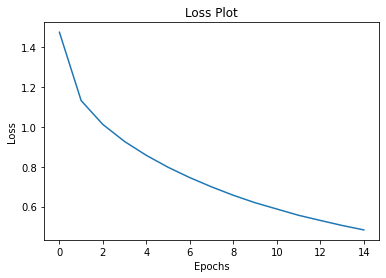

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tokenizer.index_word[predicted_id]
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Prediction Caption: group of people stand on bench <end>


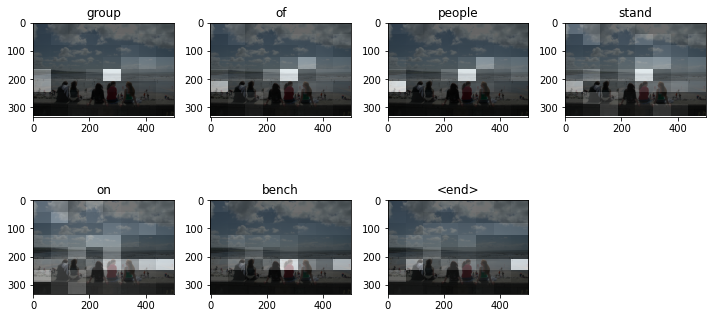

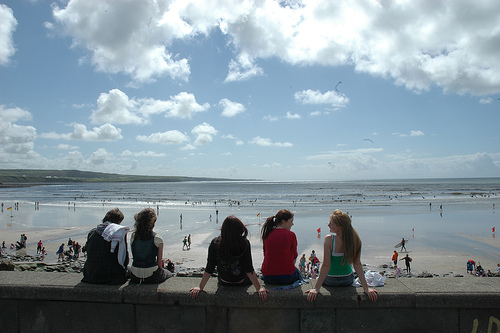

In [ ]:
image = PATH+'1048710776_bb5b0a5c7c.jpg'

result, attention_plot = evaluate(image)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
# opening the image
Image.open(image)